First test Input Properties w/o reservoir. weak selectivity and not pertained

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2

In [2]:
from brian2 import ms,Hz,NeuronGroup,Synapses
from numpy import pi,sin,cos,exp

In [3]:
b2.start_scope()
# Parameters
N_s = 2**5 # Sensory Subgroup Size
nN = 8 # Number of Subgroups
N_r = 2**6 # Echo group size
tau = 10*ms # Syanaptic time constant (homogeneous)
# rate = lambda g: 0.4*(1+np.tanh(0.4*g-3))/tau # Neuron Transfer function
p = 0.35 # Exc projection probability between two groups
wFF = 2100/4 # Sensory to Echo Weight constant
wFB = 200/4  # Echo back to Sensory Weight COnstant 
A = 2; k1 = 1; k2 = 0.25 # within subgroup connection parameter
S_ext = 10 * Hz # external Input Strength
sig_ext = N_s/32 # external Input width
stim = b2.TimedArray(np.hstack((np.zeros(2),np.ones(2),np.zeros(18))),dt=50*ms) # stimlus only between 100-200 ms
# #%%
# # Transfer Func
# phi = lambda g : 0.4*(1+np.tanh(0.4*g-3))/tau
# g = np.linspace(0,12)
# plt.plot(g,phi(g)/Hz)
# #%%
eqa_N = '''
dg/dt = -g/tau + s_ext: 1 # summed synaptic variable
r = 0.4*(1+tanh(0.4*g-3))/tau: Hz # firing rate
# external input, center should be translational invariant, choose pi (N_s/2)
# note here only one subgroup included, yet to be modified
s_ext = stim(t) * S_ext * exp(-(i-N_s/2)**2/2/sig_ext**2) / sqrt(2*pi) / sig_ext : Hz
'''
PSC ='g_post += w' # w: synaptic weight variable


In [4]:
# Create NeuronGroups and Connections
# two Poission Neuron Groups
G   = NeuronGroup(N_s*nN,eqa_N,threshold='rand()<r*dt',name='sensory')
G_r = NeuronGroup(N_r, eqa_N,threshold='rand()<r*dt',name='random')

In [5]:
# within subgroups
for iG in range(nN):
    start = iG*N_s
    end = start+N_s
    G_sub = G[start:end]
    S = Synapses(G_sub,G_sub,'w : 1',on_pre=PSC)
    S.connect(condition='i!=j')
    for ii in range(N_s):
        for jj in range(ii):
            u = (ii-jj)*2*pi/N_s
            w_temp = A*exp(k1*(cos(u)-1)) - A*exp(k2*(cos(u)-1))
            S.w[ii,jj] = w_temp
            S.w[jj,ii] = w_temp
# between two groups
S_FF = Synapses(G,G_r,'w : 1',on_pre=PSC) # Feedforward from sensory to echo
S_FF.connect() # connect all pairs
S_FB = Synapses(G_r,G,'w : 1',on_pre=PSC) # Feedback from echo to sensory
S_FB.connect() # connect all pairs

WARNING    C:\Users\golde\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\golde\.cython\brian_extensions\_cython_magic_e79eec19261d6a2ebb5f6bc91816fe06.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [6]:
# random excitatory projection between two groups
C = np.random.uniform(size=(N_s*nN,N_r))<p
N_exc_s = np.sum(C,0)
N_exc_r = np.sum(C,1)
# S_FF.w[:,:] = -wFF/(N_s*nN) + wFF*C/N_exc_s[None,:] 
# S_FB.w[:,:] = -wFB/N_r    + wFB*C.T/N_exc_r[None,:]
# for ii in range(N_r):
#     S_FF.w[:,ii] = -wFF/(N_s*nN) + wFF*C[:,ii]/N_exc_s[ii]
# for jj in range(N_s*nN):
#     S_FB.w[:,jj] = -wFB/N_r    + wFB*C[jj,:]/N_exc_r[j

In [7]:
# print(np.sum(S_FF.w[:,np.random.choice(N_r )],0))
# print(np.sum(S_FB.w[:,np.random.choice(N_s*nN)],0))


In [8]:
# Monitor
sp_G = b2.SpikeMonitor(G)
r_G = b2.StateMonitor(G,'r',record=True)
g_G = b2.StateMonitor(G,'g',record=[N_s/2,N_s])
I_ext = b2.StateMonitor(G,'s_ext',record=[N_s/2,N_s])

In [9]:
b2.run(1100*ms)


WARNING    The expression "N_s / 2" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. [brian2.parsing.bast.floating_point_division]
INFO       No numerical integration method specified for group 'random', using method 'exact' (took 0.70s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sensory', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


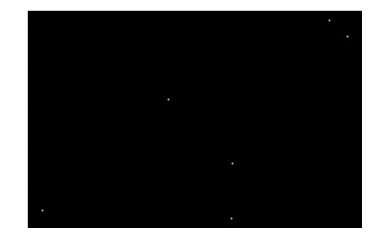

In [10]:
ind = np.logical_and(sp_G.i >= N_s, sp_G.i < 2*N_s)
plt.plot(sp_G.t[ind] / ms, sp_G.i[ind], '.', markersize=2)


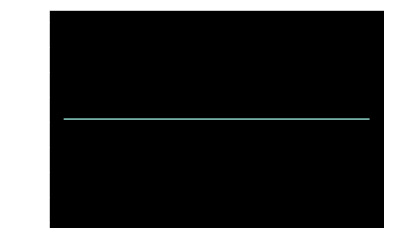

In [11]:
plt.plot(r_G.t,r_G.r[0,:])

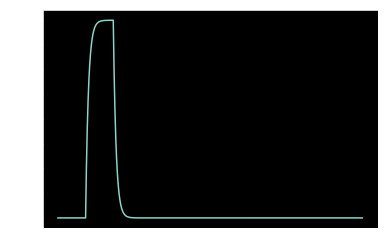

In [12]:
plt.plot(g_G.t,g_G.g[0,:])


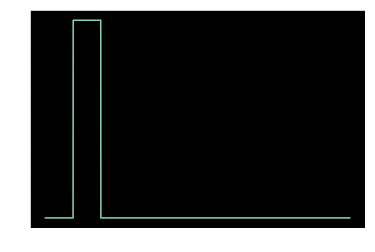

In [13]:
plt.plot(I_ext.t,I_ext.s_ext[0,:])


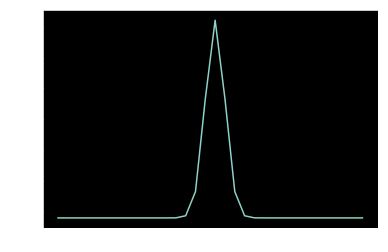

In [14]:
plt.plot(r_G.r[0:N_s,np.where(r_G.t==200*ms)[0]])


Then add reservoir, there is barely selectivity 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2

In [17]:
from brian2 import ms,Hz,NeuronGroup,Synapses
from numpy import pi,sin,cos,exp

In [18]:
b2.start_scope()
# Parameters
N_s = 2**5 # Sensory Subgroup Size
nN = 8 # Number of Subgroups
N_r = 2**6 # Echo group size
tau = 10*ms # Syanaptic time constant (homogeneous)
# rate = lambda g: 0.4*(1+np.tanh(0.4*g-3))/tau # Neuron Transfer function
p = 0.35 # Exc projection probability between two groups
wFF = 2100/4 # Sensory to Echo Weight constant
wFB = 200/4  # Echo back to Sensory Weight COnstant 
A = 2; k1 = 1; k2 = 0.25 # within subgroup connection parameter
S_ext = 10 * Hz # external Input Strength
sig_ext = N_s/32 # external Input width
stim = b2.TimedArray(np.hstack((np.zeros(2),np.ones(2),np.zeros(18))),dt=50*ms) # stimlus only between 100-200 ms
# #%%
# # Transfer Func
# phi = lambda g : 0.4*(1+np.tanh(0.4*g-3))/tau
# g = np.linspace(0,12)
# plt.plot(g,phi(g)/Hz)
# #%%
eqa_N = '''
dg/dt = -g/tau + s_ext: 1 # summed synaptic variable
r = 0.4*(1+tanh(0.4*g-3))/tau: Hz # firing rate
# external input, center should be translational invariant, choose pi (N_s/2)
# note here only one subgroup included, yet to be modified
s_ext = stim(t) * S_ext * exp(-(i-N_s/2)**2/2/sig_ext**2) / sqrt(2*pi) / sig_ext : Hz
'''
PSC ='g_post += w' # w: synaptic weight variable


In [19]:
# Create NeuronGroups and Connections
# two Poission Neuron Groups
G   = NeuronGroup(N_s*nN,eqa_N,threshold='rand()<r*dt',name='sensory')
G_r = NeuronGroup(N_r, eqa_N,threshold='rand()<r*dt',name='random')

In [20]:
# within subgroups
for iG in range(nN):
    start = iG*N_s
    end = start+N_s
    G_sub = G[start:end]
    S = Synapses(G_sub,G_sub,'w : 1',on_pre=PSC)
    S.connect(condition='i!=j')
    for ii in range(N_s):
        for jj in range(ii):
            u = (ii-jj)*2*pi/N_s
            w_temp = A*exp(k1*(cos(u)-1)) - A*exp(k2*(cos(u)-1))
            S.w[ii,jj] = w_temp
            S.w[jj,ii] = w_temp
# between two groups
S_FF = Synapses(G,G_r,'w : 1',on_pre=PSC) # Feedforward from sensory to echo
S_FF.connect() # connect all pairs
S_FB = Synapses(G_r,G,'w : 1',on_pre=PSC) # Feedback from echo to sensory
S_FB.connect() # connect all pairs

In [21]:
# random excitatory projection between two groups
C = np.random.uniform(size=(N_s*nN,N_r))<p
N_exc_s = np.sum(C,0)
N_exc_r = np.sum(C,1)
# S_FF.w[:,:] = -wFF/(N_s*nN) + wFF*C/N_exc_s[None,:] 
# S_FB.w[:,:] = -wFB/N_r    + wFB*C.T/N_exc_r[None,:]
for ii in range(N_r):
    S_FF.w[:,ii] = -wFF/(N_s*nN) + wFF*C[:,ii]/N_exc_s[ii]
for jj in range(N_s*nN):
    S_FB.w[:,jj] = -wFB/N_r    + wFB*C[jj,:]/N_exc_r[jj]

In [22]:
# print(np.sum(S_FF.w[:,np.random.choice(N_r )],0))
# print(np.sum(S_FB.w[:,np.random.choice(N_s*nN)],0))


In [23]:
# Monitor
sp_G = b2.SpikeMonitor(G)
r_G = b2.StateMonitor(G,'r',record=True)
g_G = b2.StateMonitor(G,'g',record=[N_s/2,N_s])
I_ext = b2.StateMonitor(G,'s_ext',record=[N_s/2,N_s])

In [24]:
b2.run(1100*ms)


INFO       No numerical integration method specified for group 'random', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sensory', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


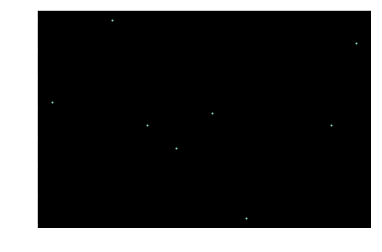

In [25]:
ind = np.logical_and(sp_G.i >= N_s, sp_G.i < 2*N_s)
plt.plot(sp_G.t[ind] / ms, sp_G.i[ind], '.', markersize=2)


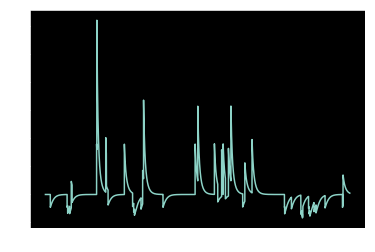

In [26]:
plt.plot(r_G.t,r_G.r[0,:])

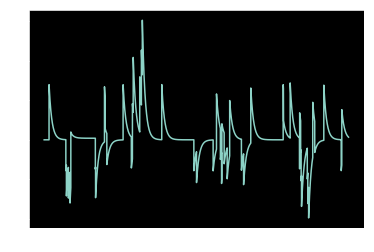

In [27]:
plt.plot(g_G.t,g_G.g[0,:])


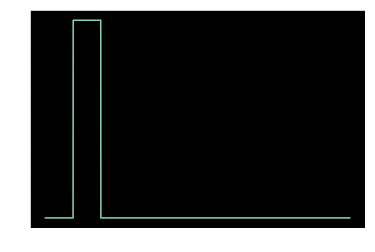

In [28]:
plt.plot(I_ext.t,I_ext.s_ext[0,:])


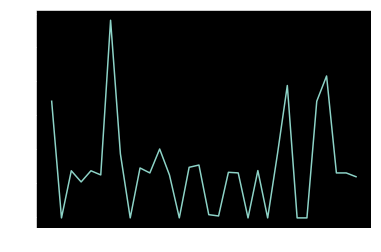

In [29]:
plt.plot(r_G.r[0:N_s,np.where(r_G.t==200*ms)[0]])


Stronger input: weak selectivity not amplified by reservoir

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2

In [32]:
from brian2 import ms,Hz,NeuronGroup,Synapses
from numpy import pi,sin,cos,exp

In [33]:
b2.start_scope()
# Parameters
N_s = 2**5 # Sensory Subgroup Size
nN = 8 # Number of Subgroups
N_r = 2**6 # Echo group size
tau = 10*ms # Syanaptic time constant (homogeneous)
# rate = lambda g: 0.4*(1+np.tanh(0.4*g-3))/tau # Neuron Transfer function
p = 0.35 # Exc projection probability between two groups
wFF = 2100/4 # Sensory to Echo Weight constant
wFB = 200/4  # Echo back to Sensory Weight COnstant 
A = 2; k1 = 1; k2 = 0.25 # within subgroup connection parameter
S_ext = 100 * Hz # external Input Strength
sig_ext = N_s/32 # external Input width
stim = b2.TimedArray(np.hstack((np.zeros(2),np.ones(2),np.zeros(18))),dt=50*ms) # stimlus only between 100-200 ms
# #%%
# # Transfer Func
# phi = lambda g : 0.4*(1+np.tanh(0.4*g-3))/tau
# g = np.linspace(0,12)
# plt.plot(g,phi(g)/Hz)
# #%%
eqa_N = '''
dg/dt = -g/tau + s_ext: 1 # summed synaptic variable
r = 0.4*(1+tanh(0.4*g-3))/tau: Hz # firing rate
# external input, center should be translational invariant, choose pi (N_s/2)
# note here only one subgroup included, yet to be modified
s_ext = stim(t) * S_ext * exp(-(i-N_s/2)**2/2/sig_ext**2) / sqrt(2*pi) / sig_ext : Hz
'''
PSC ='g_post += w' # w: synaptic weight variable


In [34]:
# Create NeuronGroups and Connections
# two Poission Neuron Groups
G   = NeuronGroup(N_s*nN,eqa_N,threshold='rand()<r*dt',name='sensory')
G_r = NeuronGroup(N_r, eqa_N,threshold='rand()<r*dt',name='random')

In [35]:
# within subgroups
for iG in range(nN):
    start = iG*N_s
    end = start+N_s
    G_sub = G[start:end]
    S = Synapses(G_sub,G_sub,'w : 1',on_pre=PSC)
    S.connect(condition='i!=j')
    for ii in range(N_s):
        for jj in range(ii):
            u = (ii-jj)*2*pi/N_s
            w_temp = A*exp(k1*(cos(u)-1)) - A*exp(k2*(cos(u)-1))
            S.w[ii,jj] = w_temp
            S.w[jj,ii] = w_temp
# between two groups
S_FF = Synapses(G,G_r,'w : 1',on_pre=PSC) # Feedforward from sensory to echo
S_FF.connect() # connect all pairs
S_FB = Synapses(G_r,G,'w : 1',on_pre=PSC) # Feedback from echo to sensory
S_FB.connect() # connect all pairs

In [36]:
# random excitatory projection between two groups
C = np.random.uniform(size=(N_s*nN,N_r))<p
N_exc_s = np.sum(C,0)
N_exc_r = np.sum(C,1)
# S_FF.w[:,:] = -wFF/(N_s*nN) + wFF*C/N_exc_s[None,:] 
# S_FB.w[:,:] = -wFB/N_r    + wFB*C.T/N_exc_r[None,:]
for ii in range(N_r):
    S_FF.w[:,ii] = -wFF/(N_s*nN) + wFF*C[:,ii]/N_exc_s[ii]
for jj in range(N_s*nN):
    S_FB.w[:,jj] = -wFB/N_r    + wFB*C[jj,:]/N_exc_r[jj]

In [37]:
# print(np.sum(S_FF.w[:,np.random.choice(N_r )],0))
# print(np.sum(S_FB.w[:,np.random.choice(N_s*nN)],0))


In [38]:
# Monitor
sp_G = b2.SpikeMonitor(G)
r_G = b2.StateMonitor(G,'r',record=True)
g_G = b2.StateMonitor(G,'g',record=[N_s/2,N_s])
I_ext = b2.StateMonitor(G,'s_ext',record=[N_s/2,N_s])

In [39]:
b2.run(1100*ms)


INFO       No numerical integration method specified for group 'random', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sensory', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


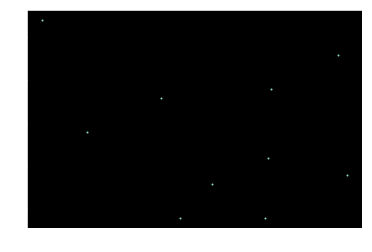

In [40]:
ind = np.logical_and(sp_G.i >= N_s, sp_G.i < 2*N_s)
plt.plot(sp_G.t[ind] / ms, sp_G.i[ind], '.', markersize=2)


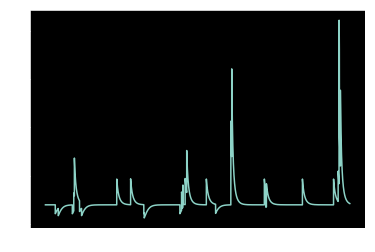

In [41]:
plt.plot(r_G.t,r_G.r[0,:])

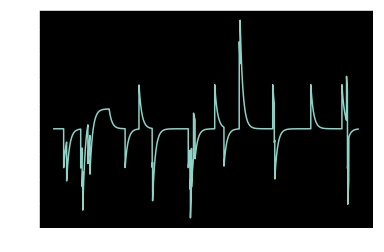

In [42]:
plt.plot(g_G.t,g_G.g[0,:])


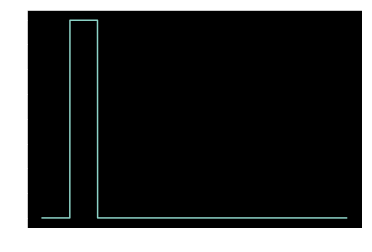

In [43]:
plt.plot(I_ext.t,I_ext.s_ext[0,:])


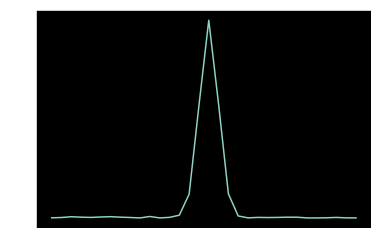

In [44]:
plt.plot(r_G.r[0:N_s,np.where(r_G.t==200*ms)[0]])


strong input + strong reservoir, blow up

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2

In [47]:
from brian2 import ms,Hz,NeuronGroup,Synapses
from numpy import pi,sin,cos,exp

In [48]:
b2.start_scope()
# Parameters
N_s = 2**5 # Sensory Subgroup Size
nN = 8 # Number of Subgroups
N_r = 2**6 # Echo group size
tau = 10*ms # Syanaptic time constant (homogeneous)
# rate = lambda g: 0.4*(1+np.tanh(0.4*g-3))/tau # Neuron Transfer function
p = 0.35 # Exc projection probability between two groups
wFF = 2100/2 # Sensory to Echo Weight constant
wFB = 200/2  # Echo back to Sensory Weight COnstant 
A = 2; k1 = 1; k2 = 0.25 # within subgroup connection parameter
S_ext = 100 * Hz # external Input Strength
sig_ext = N_s/32 # external Input width
stim = b2.TimedArray(np.hstack((np.zeros(2),np.ones(2),np.zeros(18))),dt=50*ms) # stimlus only between 100-200 ms
# #%%
# # Transfer Func
# phi = lambda g : 0.4*(1+np.tanh(0.4*g-3))/tau
# g = np.linspace(0,12)
# plt.plot(g,phi(g)/Hz)
# #%%
eqa_N = '''
dg/dt = -g/tau + s_ext: 1 # summed synaptic variable
r = 0.4*(1+tanh(0.4*g-3))/tau: Hz # firing rate
# external input, center should be translational invariant, choose pi (N_s/2)
# note here only one subgroup included, yet to be modified
s_ext = stim(t) * S_ext * exp(-(i-N_s/2)**2/2/sig_ext**2) / sqrt(2*pi) / sig_ext : Hz
'''
PSC ='g_post += w' # w: synaptic weight variable


In [49]:
# Create NeuronGroups and Connections
# two Poission Neuron Groups
G   = NeuronGroup(N_s*nN,eqa_N,threshold='rand()<r*dt',name='sensory')
G_r = NeuronGroup(N_r, eqa_N,threshold='rand()<r*dt',name='random')

In [50]:
# within subgroups
for iG in range(nN):
    start = iG*N_s
    end = start+N_s
    G_sub = G[start:end]
    S = Synapses(G_sub,G_sub,'w : 1',on_pre=PSC)
    S.connect(condition='i!=j')
    for ii in range(N_s):
        for jj in range(ii):
            u = (ii-jj)*2*pi/N_s
            w_temp = A*exp(k1*(cos(u)-1)) - A*exp(k2*(cos(u)-1))
            S.w[ii,jj] = w_temp
            S.w[jj,ii] = w_temp
# between two groups
S_FF = Synapses(G,G_r,'w : 1',on_pre=PSC) # Feedforward from sensory to echo
S_FF.connect() # connect all pairs
S_FB = Synapses(G_r,G,'w : 1',on_pre=PSC) # Feedback from echo to sensory
S_FB.connect() # connect all pairs

In [51]:
# random excitatory projection between two groups
C = np.random.uniform(size=(N_s*nN,N_r))<p
N_exc_s = np.sum(C,0)
N_exc_r = np.sum(C,1)
# S_FF.w[:,:] = -wFF/(N_s*nN) + wFF*C/N_exc_s[None,:] 
# S_FB.w[:,:] = -wFB/N_r    + wFB*C.T/N_exc_r[None,:]
for ii in range(N_r):
    S_FF.w[:,ii] = -wFF/(N_s*nN) + wFF*C[:,ii]/N_exc_s[ii]
for jj in range(N_s*nN):
    S_FB.w[:,jj] = -wFB/N_r    + wFB*C[jj,:]/N_exc_r[jj]

In [52]:
# print(np.sum(S_FF.w[:,np.random.choice(N_r )],0))
# print(np.sum(S_FB.w[:,np.random.choice(N_s*nN)],0))


In [53]:
# Monitor
sp_G = b2.SpikeMonitor(G)
r_G = b2.StateMonitor(G,'r',record=True)
g_G = b2.StateMonitor(G,'g',record=[N_s/2,N_s])
I_ext = b2.StateMonitor(G,'s_ext',record=[N_s/2,N_s])

In [54]:
b2.run(1100*ms)


INFO       No numerical integration method specified for group 'random', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sensory', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


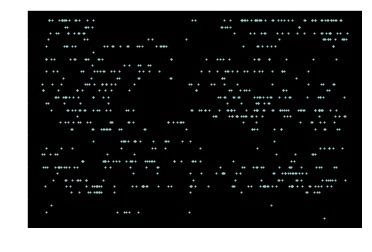

In [55]:
ind = np.logical_and(sp_G.i >= N_s, sp_G.i < 2*N_s)
plt.plot(sp_G.t[ind] / ms, sp_G.i[ind], '.', markersize=2)


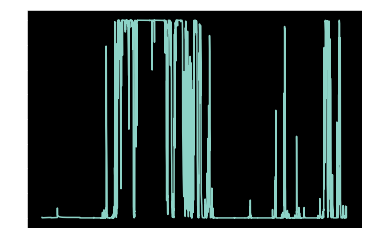

In [56]:
plt.plot(r_G.t/ms,r_G.r[0,:])

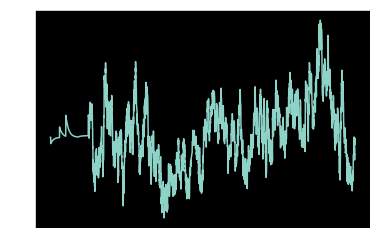

In [57]:
plt.plot(g_G.t/ms,g_G.g[0,:])


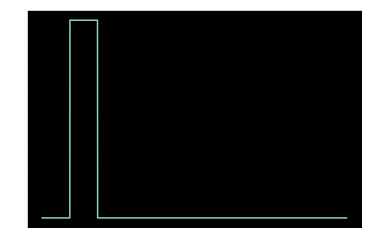

In [58]:
plt.plot(I_ext.t/ms,I_ext.s_ext[0,:])


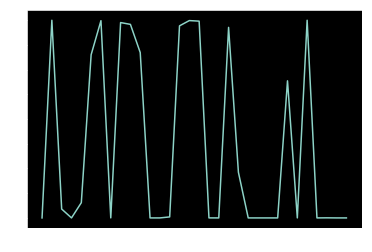

In [59]:
plt.plot(r_G.r[0:N_s,np.where(r_G.t==200*ms)[0]])
